# Assignment 4 - Computer Applications in Physics
**Yu Jiawei (586067) Humblodt-Universität zu Berlin**

Simulation of the trajectory (orbit) of the Earth around the Sun.

We are going to solve the ODE $\dfrac{d^2}{dt^2}\vec{r}=\dfrac{F_G}{m}$ numerically so that we can obtain the trajectory $\vec{r}(t)$ in both laboratory coordinate system and center-of-mass frame.

In [1]:
# import some necessary packets
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as mpl

In [2]:
# Some Astro-constants

m_Sun = 1.989e30 # Mass of Sun in (kg)
m_Earth = 5.972e24 # Mass of Earth in (kg)
AU = 1.496e11 # 1 astronomical unit in (m)
Year = 365.25*24*60*60 # 1 year in (s)
G = 6.674e-11 # Gravitational constant in (m^3.kg^−1.s^-2)

# Now we convert them to astronomical system of units (IAU)
M_Sun = m_Sun/m_Sun
M_Earth = m_Earth/m_Sun
M = [M_Sun, M_Earth]
G = 4*np.pi**2

## Part 1 Sun in the Coordinate Origin

In [3]:
# Evaluating the gravitational force
# REFERENCE: Kepler-Three-Body-Problem-With-Extra.ipynb

def Grav_Force(state_vec, mass, planet_No, direc):
    
    # A check first
    if len(state_vec)%4 != 0:
        raise ValueError('The state vector dose not correspond the number of planets!')
    
    # Set the direction for which we will be evaluating
    if direc == 'x':
        # the first two component for a planet represents "x"
        j = 0
    elif direc == 'y':
        # the last two component for a planet represents "y"
        j = 2
    else:
        raise ValueError('The input can only be "x" or "y"!')
    
    # Sum up the gravitational force caused by every other planets
    num_planets = int(len(state_vec)/4)
    grav_output = 0.
    for i in np.arange(num_planets):
        if i == planet_No:
            pass # pass the current planet itself
        else:
            # The gravity force
            grav = G * mass[i] * mass[planet_No] / Distance(state_vec, planet_No, i)**2
            # Multiply with the direction-cosine
            grav *= - (state_vec[planet_No*4+j] - state_vec[i*4+j]) / Distance(state_vec, planet_No, i)
            # Add the forces up
            grav_output += grav
    
    return grav_output


# The distance between 2 planets

def Distance(state_vec, p1, p2):
    dx = state_vec[p1*4] - state_vec[p2*4]
    dy = state_vec[p1*4+2] - state_vec[p2*4+2]
    d = np.sqrt(dx**2 + dy**2)
    return d

Here is our ODE system in the form the time-derivative of state vector.

$$ \begin{array}{ll}
\vec r_{new}=f(\vec r_{old},t) &= \dfrac{d}{dt}[x_1,\dot x_1,y_1,\dot y_1,x_2,\dot x_2,y_2,\dot y_2]^T \\
&= \left[\dot x_1,\dfrac{F_{x_1}}{m_1},\dot y_1,\dfrac{F_{y_1}}{m_1},\dot x_2,\dfrac{F_{x_2}}{m_2},\dot y_2,\dfrac{F_{y_2}}{m_2}\right]^T
\end{array} $$

where $$F_{x_k}=\sum_{n} G\frac{M_i m_k}{r_{ik}^2} \cos(\theta_x)$$ are the sum of gravitational forces of object $k$ in direction $x$ from every other objects.

In [4]:
# Define a state updating function (SUF)
# REFERENCE: Kepler-Three-Body-Problem-With-Extra.ipynb

def Next_State(t, state_vec):
    
    # A check first
    if len(state_vec)%4 != 0:
        raise ValueError('The state vector dose not correspond the number of planets!')
    
    # Assigning values to the new state vector
    num_planets = int(len(state_vec)/4)
    New_state_vec = np.zeros_like(state_vec)
    for i in np.arange(num_planets):
        # For each planet "i" there are 4 components "j"
        j = i*4
        New_state_vec[j+0] = state_vec[j+1]
        New_state_vec[j+1] = Grav_Force(state_vec, M, i, direc='x') / M[i]
        New_state_vec[j+2] = state_vec[j+3]
        New_state_vec[j+3] = Grav_Force(state_vec, M, i, direc='y') / M[i]
    
    return New_state_vec

To solve our ODE numerically, initial conditions are required by all means.

In [5]:
# Initial parameters
r_ES = 1.496e11 # Initial distance between Sun and Earth in (m)
r_ES = r_ES/AU
v_E = 29.78e3 # Initial velocity of Earth in (m/s)
v_E = v_E*Year/AU

# Initial state vector
Ini_Sun = [0, 0, 0, 0]
Ini_Earth = [r_ES, 0, 0, v_E]
y0 = Ini_Sun + Ini_Earth

As what we did in the exercise section, our ODE can be solved simply by `odeint` as follows.

In [17]:
# Solve the ODE with "odeint"

#time_year = np.linspace(0,1,10001)
#sol0 = scipy.integrate.odeint(Next_State, y0, time_year, rtol=1e-10)

Unfortunately, however, if we want the ODE-solver to be terminated under a specific condition, for instance, when the trajectory curve has already been closed, `odeint` fails to support this advanced feature which is called "event handling". Unlike using a single command `Option = odeset('Events',@eventfun);` in MATLAB, scipy.integrate provides another more customized function `solve_ivp(fun, t_span, y0[, method, t_eval, …])` for the initial value problem. Note that the calling signature of the function is `fun(t, y)`.

In [7]:
# Define our event function indicating whether the trajectory is closed or not
def Curve_close(t, y):
    return y[4+2] + 1e-8

# The necessary attributes of the Function
Curve_close.terminal = True
Curve_close.direction = 1 # from neg to pos

# Solve the ODE with "solve_ivp"
time_year = np.linspace(0,3,10001)
sol1 = scipy.integrate.solve_ivp(Next_State, [0,3], y0, t_eval=time_year, events=Curve_close, rtol=1e-10)

It should be noticed that shape the attribute `y` returned by `solve_ivp` $[\text{len}(y_0), \text{len}(t)]$ is exactly the transpose of the one from `odeint` $[\text{len}(t), \text{len}(y_0)]$. 
As for the criteria if the trajectory is closed, I expediently choose $y_E=0$ and `Curve_close.direction = 1`, indicating that the event happens only when $y_E$ goes from negative to positive. Additionally, a arbitrarily small positive shift $\varepsilon = 10^{-8}$ is added so that our integration won't cease at its initial point. 
Other criteria such as whether the distance $\sqrt{(x-x_0)^2+(y-y_0)^2}$ is smaller than a tolerence can be difficult to apply since our solution is precise enough to distinguish itself from the previous curve.

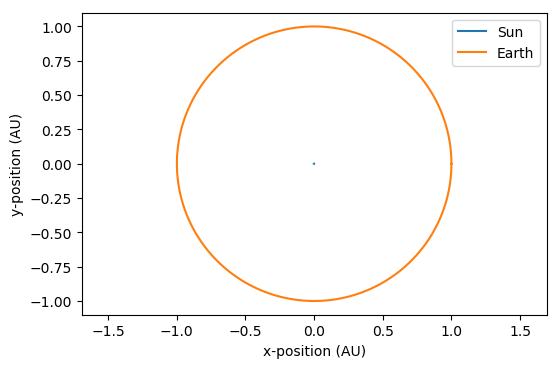

In [8]:
# Plot the orbit for 1 year
Graph1 = mpl.figure(dpi=100)
#mpl.plot(sol0[:,0], sol0[:,2], label='Sun')
#mpl.plot(sol0[:,4], sol0[:,6], label='Earth')
mpl.plot(sol1.y[0,:], sol1.y[2,:], label='Sun')
mpl.plot(sol1.y[4,:], sol1.y[6,:], label='Earth')

mpl.xlabel("x-position (AU)")
mpl.ylabel("y-position (AU)")
mpl.legend(loc='best')
mpl.axis("equal")
mpl.show()

## Part 2 In the Center-of-Mass Frame

The position vector of the center of mass related to sun is

$$ \vec r_{C}^{Sun} = \frac{m_E}{m_E+m_S}(\vec r_{Earth} - \vec r_{Sun}) $$

so its clear that the position of sun in the Center-of-Mass Frame is

$$\vec r_{Sun}^{C} = -r_{C}^{Sun} = \frac{m_E}{m_E+m_S}(\vec r_{Sun} - \vec r_{Earth})  $$

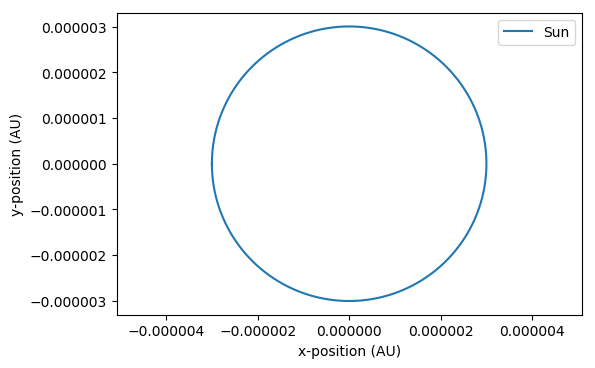

In [19]:
r_SE = np.zeros_like(sol1.y[0:2,:])
r_SE[0,:] = sol1.y[0,:]-sol1.y[4,:]
r_SE[1,:] = sol1.y[2,:]-sol1.y[6,:]
COM_Sun = r_SE * M_Earth / (M_Sun+M_Earth)

Graph2 = mpl.figure(dpi=100)
mpl.plot(COM_Sun[0,:], COM_Sun[1,:], label='Sun')
mpl.xlabel("x-position (AU)")
mpl.ylabel("y-position (AU)")
mpl.legend(loc='best')
mpl.axis("equal")
mpl.show()

## Part 3 Some other Initial Values

We will see what will happen if the initial distance is set as $0.7r_{ES}$ or $1.3r_{ES}$.

In [20]:
# Another initial state vector
y3 = [0, 0, 0, 0, 0.7*r_ES, 0, 0, v_E]
y4 = [0, 0, 0, 0, 1.3*r_ES, 0, 0, v_E]

# Solve the ODE with "solve_ivp"
# Set the timespan to be 3 years
time_year = np.linspace(0,3,10001)
sol3 = scipy.integrate.solve_ivp(Next_State, [0,3], y3, t_eval=time_year, events=Curve_close, rtol=1e-10)
sol4 = scipy.integrate.solve_ivp(Next_State, [0,3], y4, t_eval=time_year, events=Curve_close, rtol=1e-10)

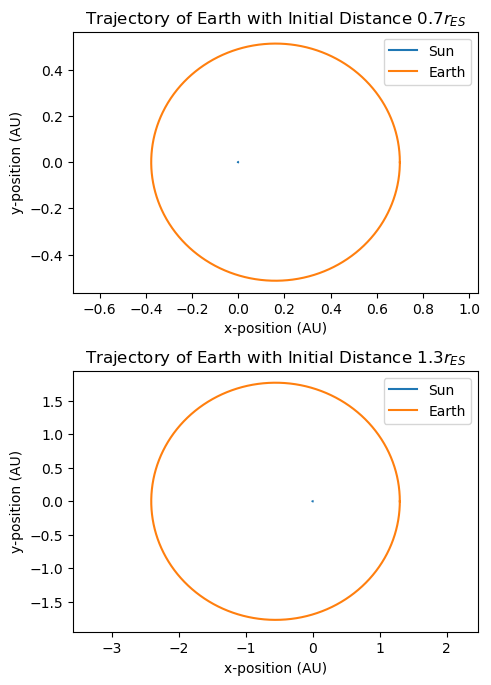

In [21]:
# Plot the orbit
Graph3 = mpl.figure(dpi=100)
ax1 = mpl.subplot(2,1,1)
mpl.plot(sol3.y[0,:], sol3.y[2,:], label='Sun')
mpl.plot(sol3.y[4,:], sol3.y[6,:], label='Earth')
mpl.xlabel("x-position (AU)")
mpl.ylabel("y-position (AU)")
mpl.title('Trajectory of Earth with Initial Distance $0.7r_{ES}$')
mpl.legend(loc='best')
mpl.axis("equal")

ax2 = mpl.subplot(2,1,2)
mpl.plot(sol4.y[0,:], sol4.y[2,:], label='Sun')
mpl.plot(sol4.y[4,:], sol4.y[6,:], label='Earth')
mpl.xlabel("x-position (AU)")
mpl.ylabel("y-position (AU)")
mpl.title('Trajectory of Earth with Initial Distance $1.3r_{ES}$')
mpl.legend(loc='best')
mpl.axis("equal")

mpl.subplots_adjust(bottom=0.1,right=0.8,top=1.6,hspace=0.3)
mpl.show()